In [2]:
#importing packages and classes from tensorflow to implement LSTM and GRU and SKLearn packages from ML implementation
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
import os
from sentence_transformers import SentenceTransformer
from keras.layers import LSTM #class for LSTM training
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional,GRU #loading GRU and bidirectional model
import pickle


c:\users\krutik\appdata\local\programs\python\python38\lib\site-packages\huggingface_hub\snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [3]:
#define minmax scaler class for features normalization
normalized = MinMaxScaler((0, 1))

In [4]:
#create bert model object
bert = SentenceTransformer('nli-distilroberta-base-v2')
print("Bert object initialized")

c:\users\krutik\appdata\local\programs\python\python38\lib\site-packages\transformers\modeling_utils.py:1359: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

Bert object initialized


In [5]:
#load stock prices dataset
dataset = pd.read_csv("Dataset/AAPL.csv")
dataset.fillna(0, inplace = True)
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000,1
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800,0
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100,1
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600,1
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500,0
...,...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000,1
1254,2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900,1
1255,2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600,1
1256,2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100,1


In [6]:
#now load tweets dataset
tweets = pd.read_csv("Dataset/tweets.csv")
tweets

,Tweets,Label
0,RT @philstockworld: Summary of Yesterday's Web...,0
1,iTV Will Boost Apple http://t.co/8dup4cQc08 $A...,0
2,#iPhone users are more intelligent than #Samsu...,0
3,RT @philstockworld: Summary of Yesterday's Web...,0
4,2013 Wrap-Up And Trading Set Review - Part III...,0
...,...,...
1253,RT @engadget: Miss anything from today's #WWDC...,1
1254,RT @carlquintanilla: #WWDC14 TV madness. @CNBC...,1
1255,RT @engadget: Miss anything from today's #WWDC...,1
1256,.@dasan Why not? Everyone loves the idea of a ...,1


In [7]:
#now extract features from tweets using BERT model
if os.path.exists("model/bert.npy"):
    tweets_features = np.load("model/bert.npy")#if tweets features already extarcted then load it 
else:
    #now apply bert model on tweets to extract features and then save the features 
    tweets = tweets['Tweets']
    embeddings = bert.encode(tweets, convert_to_tensor=True)#convert tweets to bert features
    tweets_features = embeddings.numpy()
    np.save("model/bert", tweets_features)
print("Tweets Bert Features")
print(tweets_features)

Tweets Bert Features
[[ 0.47884727 -0.17085582 -0.19215608 ... -0.8593467   0.00342204
   0.5788879 ]
 [ 0.1862817   0.30714378 -0.1579565  ...  0.7503138  -0.01108627
   0.15015505]
 [ 0.3280021   0.267668   -0.10637207 ...  0.7379003  -1.0966189
   0.6128042 ]
 ...
 [ 0.29230827 -0.26123065  0.34682733 ... -0.6132838   0.20073664
   0.6319149 ]
 [ 0.46884552 -0.36563313 -0.33744717 ... -0.16026834  0.05245114
   0.66982824]
 [-0.15445638  0.16994956 -0.25776193 ...  0.10997603 -0.31039646
  -0.13958181]]


In [8]:
#now process dataset by merging both bert features and stock prices data
dataset.drop(['Adj Close','Volume'], axis = 1,inplace=True)
dataset = dataset.values
X = dataset[:,1:dataset.shape[1]-1]
Y = dataset[:,dataset.shape[1]-1]
Y = tweets['Label'].ravel()
#now merge stock prices X and tweets features
X = np.hstack((tweets_features, X))#stacking or merging features
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle dataset
X = X[indices]
Y = Y[indices]
X = normalized.fit_transform(X)#normalized dataset to 0 and 1
print("Merge & Normalzied features")
print(X)

Merge & Normalzied features
[[0.51430645 0.39434358 0.33511909 ... 0.16724945 0.17874289 0.17578052]
 [0.35700066 0.42337626 0.7259344  ... 0.58082336 0.57381851 0.57232586]
 [0.41138635 0.47108551 0.63310284 ... 0.38148034 0.38333048 0.3777942 ]
 ...
 [0.52067922 0.59323939 0.52758341 ... 0.4785557  0.48027776 0.47598372]
 [0.28783106 0.47111124 0.77840826 ... 0.15086491 0.16139471 0.16096169]
 [0.32181551 0.56831776 0.80828512 ... 0.12364564 0.13336664 0.12758967]]


In [9]:
#split dataset into train and test where 80% dataset fro training and 20% for testing
X = X[:,2:X.shape[1]]
X = np.reshape(X, (X.shape[0], 35, 22))#reshaping features as 3 dimensional for LSTM, GRU and Bidirectional training compatible
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 1006
Testing Size (20%): 252



In [10]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [11]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    class_labels = ['Prices will Go Up', 'Prices will go Down']
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(class_labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


Existing Long Short Term Memory Accuracy  : 76.98412698412699
Existing Long Short Term Memory Precision   : 77.68627450980392
Existing Long Short Term Memory Recall      : 76.70870113493065
Existing Long Short Term Memory FMeasure    : 76.69642857142858


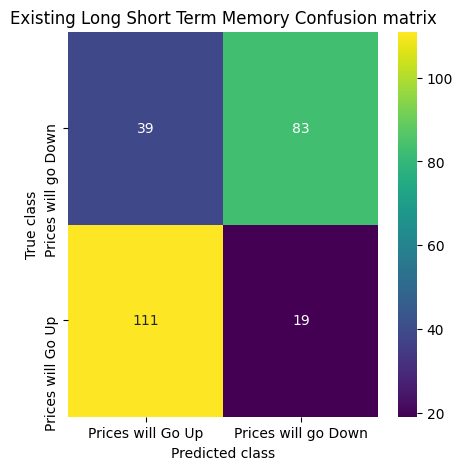

In [12]:
#training existing LSTM algorihm on bert and stock dataset features
lstm_model = Sequential()#defining deep learning sequential object
#adding LSTM layer with 100 filters to filter given input X train data to select relevant features
lstm_model.add(LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2])))
#adding dropout layer to remove irrelevant features
lstm_model.add(Dropout(0.5))
#adding another layer
lstm_model.add(Dense(100, activation='relu'))
#defining output layer for prediction
lstm_model.add(Dense(y_train.shape[1], activation='softmax'))
#compile and train LSTM model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
if os.path.exists("model/lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/lstm_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lstm_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/lstm_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    lstm_model = load_model("model/lstm_weights.hdf5")
#perform prediction on test data   
predict = lstm_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#calculate accuracy and other metrics using test label and predicted values
calculateMetrics("Existing Long Short Term Memory", predict, y_test1)


Hybrid Information Mising Module (GRU + LSTM) Accuracy  : 82.53968253968253
Hybrid Information Mising Module (GRU + LSTM) Precision   : 82.68939393939394
Hybrid Information Mising Module (GRU + LSTM) Recall      : 82.64817150063051
Hybrid Information Mising Module (GRU + LSTM) FMeasure    : 82.53858267716534


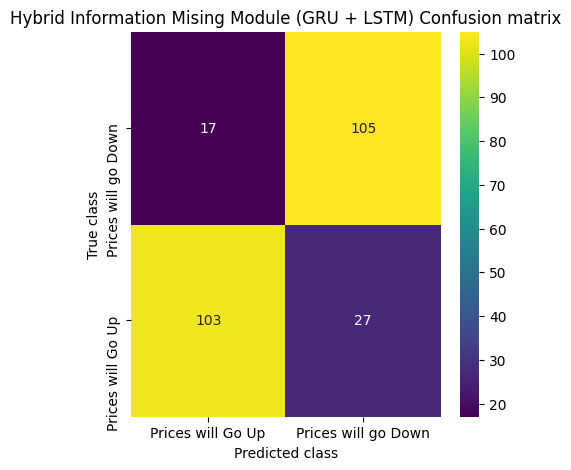

In [13]:
#train Hybrid Information Mising module using GRU and LSTM where LSTM will work on bert text features and GRU will
#work on stock prices and then merge both features using MLP layers to perform binary prediction
lstm_gru = Sequential()#defining deep learning sequential object
#adding LSTM layer to work on bert text features
lstm_gru.add(LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm_gru.add(Dropout(0.2))
#adding GRU layer for stock price data analysis
lstm_gru.add(GRU(80, return_sequences=True))
#adding dropout layer to remove irrelevant features
lstm_gru.add(Dropout(0.2))
#defining another GRU layer as MLP to merge both prices and bert text features
lstm_gru.add(GRU(64))
lstm_gru.add(Dropout(0.2))
#adding another layer
lstm_gru.add(Dense(100, activation='relu'))
#defining output layer for binary prediction
lstm_gru.add(Dense(y_train.shape[1], activation='softmax'))
#compile and train model
lstm_gru.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/propose_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/propose_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lstm_gru.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/propose_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    lstm_gru = load_model("model/propose_weights.hdf5")
#calculate accuracy and other metrics using test label and predicted values   
predict = lstm_gru.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#calculate accuracy and other metrics using test label and predicted values
calculateMetrics("Hybrid Information Mising Module (GRU + LSTM)", predict, y_test1)


Extension Hybrid Information Mising Module (GRU + LSTM + Bidirectional) Accuracy  : 84.52380952380952
Extension Hybrid Information Mising Module (GRU + LSTM + Bidirectional) Precision   : 84.82844546674333
Extension Hybrid Information Mising Module (GRU + LSTM + Bidirectional) Recall      : 84.36948297604036
Extension Hybrid Information Mising Module (GRU + LSTM + Bidirectional) FMeasure    : 84.4353293318341


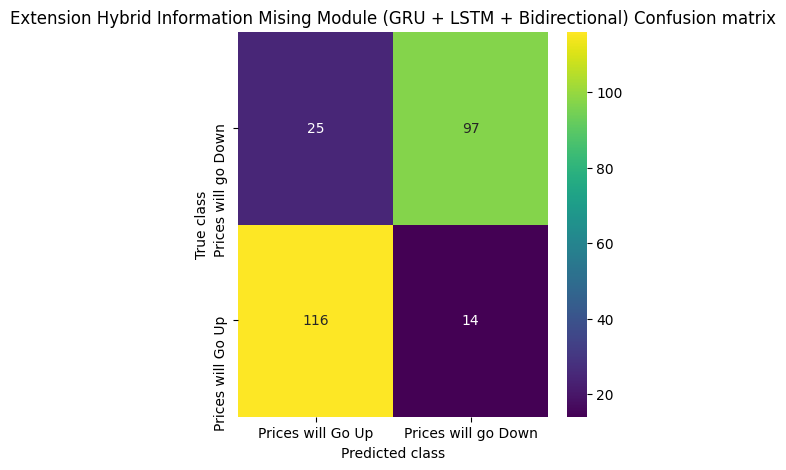

In [14]:
#now train extension model by combining multiple models such as LSTM + GRU + Bidirectional
#train Hybrid Information Mising module using GRU and LSTM  and Bidirectional where LSTM will work on bert text features 
#and GRU will work on stock prices and then merge both features using MLP layers and then bidirectinal layer
#will perform features optimization using both forward and backward direction to enhance prediction accuracy
extension_model = Sequential()#defining deep learning sequential object
#adding LSTM layer with 100 filters to filter given input X train data to select relevant features
extension_model.add(LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
extension_model.add(Dropout(0.2))
#defining another GRU layer as MLP to merge both prices and bert text features
extension_model.add(Bidirectional(GRU(80, return_sequences=True)))
#adding dropout layer to remove irrelevant features
extension_model.add(Dropout(0.2))
#adding bidirectional layer with GRU to optimize features in both forward and backward direction
extension_model.add(Bidirectional(GRU(64)))
extension_model.add(Dropout(0.2))
#adding another layer
extension_model.add(Dense(100, activation='relu'))
#defining output layer for prediction
extension_model.add(Dense(y_train.shape[1], activation='softmax'))
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    extension_model = load_model("model/extension_weights.hdf5")
#perform prediction on test data using extension model   
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#calculate accuracy and other metrics using test label and predicted values using extension model
calculateMetrics("Extension Hybrid Information Mising Module (GRU + LSTM + Bidirectional)", predict, y_test1)

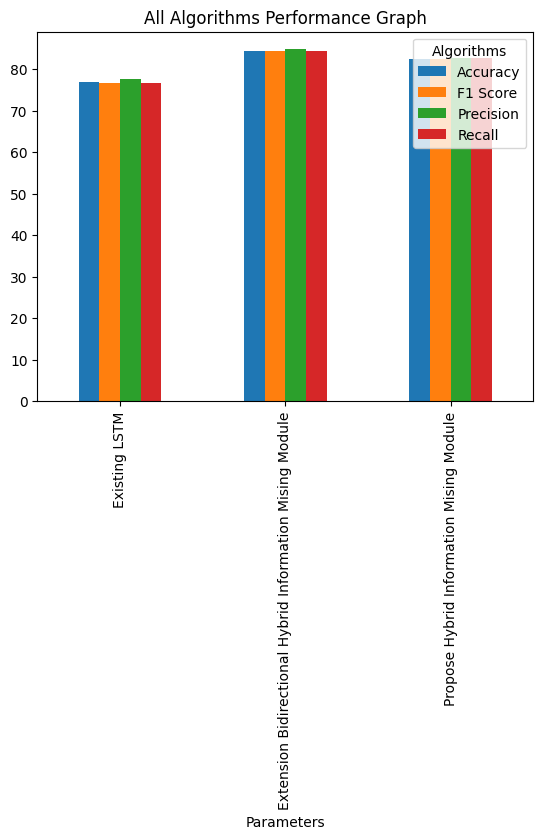

In [18]:

df = pd.DataFrame([['Existing LSTM','Precision',precision[0]],['Existing LSTM','Recall',recall[0]],['Existing LSTM','F1 Score',fscore[0]],['Existing LSTM','Accuracy',accuracy[0]],
                   ['Propose Hybrid Information Mising Module','Precision',precision[1]],['Propose Hybrid Information Mising Module','Recall',recall[1]],['Propose Hybrid Information Mising Module','F1 Score',fscore[1]],['Propose Hybrid Information Mising Module','Accuracy',accuracy[1]],
                   ['Extension Bidirectional Hybrid Information Mising Module','Precision',precision[2]],['Extension Bidirectional Hybrid Information Mising Module','Recall',recall[2]],['Extension Bidirectional Hybrid Information Mising Module','F1 Score',fscore[2]],['Extension Bidirectional Hybrid Information Mising Module','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot(index="Parameters", columns="Algorithms", values="Value").plot(kind='bar')

plt.title("All Algorithms Performance Graph")
plt.show()

In [19]:
#showing all algorithms performance in tabular format
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Existing LSTM","Propose Hybrid Information Mising Module", "Extension Bidirectional Hybrid Information Mising Module"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Existing LSTM,77.686275,76.708701,76.696429,76.984127
1,Propose Hybrid Information Mising Module,82.689394,82.648172,82.538583,82.539683
2,Extension Bidirectional Hybrid Information Mis...,84.828445,84.369483,84.435329,84.523810


In [20]:
class_labels = ['Prices will Go Up', 'Prices will go Down']
test_stock = pd.read_csv("Dataset/test_stock.csv")#read stock values
test_tweets = pd.read_csv("Dataset/test_tweets.csv") #read tweets
stocks = test_stock.values
stock = stocks[:,1:stocks.shape[1]]#read all stock data as array
tweets = test_tweets['Tweets']
embeddings = bert.encode(tweets, convert_to_tensor=True)#convert tweets to bert features
tweets_features = embeddings.numpy()
X = np.hstack((tweets_features, stock))#merge both stock and tweets features
X = normalized.transform(X)#normalized dataset to 0 and 1
X = X[:,2:X.shape[1]]
X = np.reshape(X, (X.shape[0], 35, 22))#reshape data as 3 dimensional so compatible with GRU, LSTM and bidrirectional
predict = extension_model.predict(X)#perform prediction using extension model for prices
for i in range(len(predict)):#display output values
    y_pred = np.argmax(predict[i])
    print("Tweet : "+tweets[i])
    print("Stock Price : "+str(stocks[i]))
    print("Stock Movement Prediction ====> "+class_labels[y_pred])
    print()

Tweet : $AAPL   excellent short on my part,  mentioned earlier. I don't always mention intraday trades, to busy
Stock Price : ['2013-01-09' 74.64286 75.001427 73.71285999999999 73.871429]
Stock Movement Prediction ====> Prices will Go Up

Tweet : Bad sales at $SHLD. $SNE streaming games. $AAPL streaming everything$AMZN selling everything. Should anyone own $BBY here? @jimcramer
Stock Price : ['2013-01-10' 75.507141 75.531425 73.645714 72.78714000000001]
Stock Movement Prediction ====> Prices will go Down

Tweet : RT @PeterGhostine: I guess Carl needs to buy antoher tranche of $AAPL. Sold the 552.50/555 call spread on my private stream today.
Stock Price : ['2013-01-11' 74.428574 75.045715 74.145714 74.328575]
Stock Movement Prediction ====> Prices will Go Up

Tweet : $AAPL a secret SuperBowl commercial would be an awesome surprise for Apple to tease a TV device with most of America watching. If only!
Stock Price : ['2013-01-14' 71.811432 72.5 71.215714 75.678574]
Stock Movement Predict